## Import de Librerías necesarias

In [25]:
import os
import subprocess
import pandas as pd
from datetime import date
from IPython.display import display

from pyspark import SparkContext, HiveContext
from pyspark.sql import DataFrame, SQLContext, SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import to_timestamp
from pyspark.sql import functions as f
from pyspark.sql.functions import percentile_approx
from pyspark.sql.functions import col, substring
from pyspark.sql.functions import col, isnan, when, count

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [2]:
ss = SparkSession.builder.appName("bigdatita").getOrCreate()

24/12/14 18:50:40 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


**2. Lectura de los archivos**

In [13]:
ruta = '/user/bigdatita/'
cmd = f'hdfs dfs -ls {ruta}'
lst = str(subprocess.check_output(cmd, shell=True)).strip().split('\\n')
lst = [x.split(' ')[-1] for x in lst]
lst = ['hdfs://%s'%x for x in lst if x!="items" if x!="'"]
lst

['hdfs:///user/bigdatita/taxi_trips_2023.csv',
 'hdfs:///user/bigdatita/taxi_trips_2024.csv']

**3. Lectura de archivos desde HDFS a Spark**

In [14]:
%%time
for i, file in enumerate(lst):
    print(file)
    if i==0:
        df = ss.read.csv(file, header=True, inferSchema=False)
    else:
        df = df.union(ss.read.csv(file, header=True, inferSchema=False))

hdfs:///user/bigdatita/taxi_trips_2023.csv


hdfs:///user/bigdatita/taxi_trips_2024.csv
CPU times: user 16.5 ms, sys: 134 μs, total: 16.6 ms
Wall time: 9.65 s


In [16]:
date_format = 'MM/dd/yyyy hh:mm:ss a'

df = df.withColumn('Trip Start Timestamp', to_timestamp(df['Trip Start Timestamp'], date_format).cast(TimestampType()))
df = df.withColumn('Trip End Timestamp', to_timestamp(df['Trip End Timestamp'], date_format).cast(TimestampType()))

## Filtrando información

In [17]:
df = df[(df['Trip Start Timestamp'] <= '2024-08-31')]

In [18]:
df.select(f.max("Trip Start Timestamp")).show()

+-------------------------+
|max(Trip Start Timestamp)|
+-------------------------+
|      2024-08-31 00:00:00|
+-------------------------+



In [19]:
for var in ['Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total']:
    df = df.withColumn(var, df[var].cast('float'))

In [20]:
df.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: timestamp (nullable = true)
 |-- Trip End Timestamp: timestamp (nullable = true)
 |-- Trip Seconds: string (nullable = true)
 |-- Trip Miles: string (nullable = true)
 |-- Pickup Census Tract: string (nullable = true)
 |-- Dropoff Census Tract: string (nullable = true)
 |-- Pickup Community Area: string (nullable = true)
 |-- Dropoff Community Area: string (nullable = true)
 |-- Fare: float (nullable = true)
 |-- Tips: float (nullable = true)
 |-- Tolls: float (nullable = true)
 |-- Extras: float (nullable = true)
 |-- Trip Total: float (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: string (nullable = true)
 |-- Pickup Centroid Longitude: string (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: string (nullable = true)
 |-- Dropoff Centroi

## Análisis exploratorio

In [21]:
subset = [
    'summary',
    'Trip Seconds', 'Trip Miles',
    'Pickup Census Tract', 'Dropoff Census Tract', 'Pickup Community Area',
    'Dropoff Community Area', 'Fare', 'Tips', 'Tolls', 'Extras',
    'Trip Total', 'Payment Type', 'Company', 'Pickup Centroid Latitude',
    'Pickup Centroid Longitude', 'Pickup Centroid Location',
    'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude',
    'Dropoff Centroid  Location'
]

describe_df = df.describe().toPandas()
describe_df[subset].round(2)

24/12/14 18:58:21 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,summary,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,count,10753418,10755450,4715559,4579195,10395504,9728878,10731465,10731465,10731465,10731465,10731465,10755497,10755497,10400001,10400001,10400001,9793910,9793910,9793910
1,mean,1253.8432065042018,6.6114100674546386,1.7031507928872873E10,1.703141496867211E10,35.790761563845294,26.238793517608094,22.53805691143093,2.9734957981665016,0.0495877094770661,2.274319610613869,28.014873584051113,None,None,41.902169394980184,-87.70184576171366,None,41.893577867825144,-87.6622334345335,None
2,stddev,1675.5977047159922,7.849773679995616,375165.19895197934,344238.5790196894,26.303098649815105,20.95742682723646,26.238946021802896,4.293365694862299,10.821039066251114,18.143248213625213,38.64194799701131,None,None,0.06372773833722474,0.11410234491471963,None,0.05732473692013585,0.07348264270532734,None
3,min,0,0,17031010100,17031010100,1,1,0.0,0.0,0.0,0.0,0.0,Cash,2733 - 74600 Benny Jona,41.650221676,-87.531386257,POINT (-87.5313862567 41.7204632831),41.650221676,-87.534902901,POINT (-87.5349029012 41.707311449)
4,max,9999,99.99,17031980100,17031980100,9,9,9999.75,500.0,6666.66,9693.78,9999.75,Unknown,Wolley Taxi,42.021223593,-87.913624596,POINT (-87.913624596 41.9802643146),42.021223593,-87.913624596,POINT (-87.913624596 41.9802643146)


In [22]:
%%time
deciles = df.selectExpr("percentile_approx(Fare, array(0.0, 0.01, 0.02, 0.03, 0.97, 0.98, 0.99, 1.0)) as Percentiles")
deciles.show(truncate=False)

+-----------------------------------------------------+
|Percentiles                                          |
+-----------------------------------------------------+
|[0.0, 3.25, 3.25, 3.25, 58.25, 64.25, 73.25, 9999.75]|
+-----------------------------------------------------+

CPU times: user 44.7 ms, sys: 8.21 ms, total: 52.9 ms
Wall time: 37.3 s


## Valores nulo

In [26]:
# Columnas numéricas
numeric_columns = [c for c, t in df.dtypes if t in ["double", "float"]]

# Columnas no numéricas
other_columns = [c for c, t in df.dtypes if t not in ["double", "float"]]

# Contar valores faltantes para columnas numéricas
numeric_missing = [
    count(when(isnan(col(c)) | col(c).isNull(), c)).alias(c) for c in numeric_columns
]

# Contar valores faltantes para columnas no numéricas
other_missing = [
    count(when(col(c).isNull(), c)).alias(c) for c in other_columns
]

# Combinar resultados
missings_df = df.select(numeric_missing + other_missing).toPandas()

In [27]:
display(missings_df.round())

,Fare,Tips,Tolls,Extras,Trip Total,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,24032,24032,24032,24032,24032,0,0,0,121,2079,47,6039938,6176302,359993,1026619,0,0,355496,355496,355496,961587,961587,961587


In [28]:
total = df.count()
missings_df = missings_df.T / total * 100

In [29]:
missings_df=missings_df.reset_index().sort_values(0, ascending=False)
missings_df

,index,0
12,Dropoff Census Tract,57.424608
11,Pickup Census Tract,56.156754
14,Dropoff Community Area,9.545063
21,Dropoff Centroid Longitude,8.940424
20,Dropoff Centroid Latitude,8.940424
22,Dropoff Centroid Location,8.940424
13,Pickup Community Area,3.347061
19,Pickup Centroid Location,3.305249
18,Pickup Centroid Longitude,3.305249
17,Pickup Centroid Latitude,3.305249


**Missings en las variables de Census Tract**

In [30]:
# Total de Census con missings
print(f'Missings Pickup: {missings_df[missings_df["index"] == "Dropoff Census Tract"].values}')
print(f'Missings Dropoff: {missings_df[missings_df["index"] == "Pickup Census Tract"].values}')

Missings Pickup: [['Dropoff Census Tract' 57.424608086451045]]
Missings Dropoff: [['Pickup Census Tract' 56.15675407654337]]


**Queremos ver cuáles son las diferencias de sectores con los que contamos para obtener si hay pickup o dropoff fuera de Chicago.**

In [31]:
# Número de valores únicos en la columna "Pickup Census Tract" en PySpark
pickup_unique_count = df.select("Pickup Census Tract").distinct().count()
print(f'Número de valores únicos en "Pickup Census Tract": {pickup_unique_count}')


Número de valores únicos en "Pickup Census Tract": 778


In [32]:
# Número de valores únicos en la columna "Pickup Census Tract" en PySpark
pickup_unique_count = df.select("Dropoff Census Tract").distinct().count()
print(f'Número de valores únicos en "Dropoff Census Tract": {pickup_unique_count}')


Número de valores únicos en "Dropoff Census Tract": 923


In [33]:
# Obtener los valores únicos truncados de "Dropoff Census Tract"
Pickup_unique = df.select(substring(col("Pickup Census Tract"), 1, 5).alias("truncated_Pickup")) \
    .distinct()

# Imprimir el número de valores únicos
print(f'Número de valores únicos en los primeros 5 caracteres de "Pickup Census Tract": {Pickup_unique.count()}')

# Imprimir los valores únicos
unique_values_Pickup = Pickup_unique.collect()
print("Valores únicos en los primeros 5 caracteres de 'Pickup Census Tract':")
for row in unique_values_Pickup:
    print(row["truncated_Pickup"])

Número de valores únicos en los primeros 5 caracteres de "Pickup Census Tract": 2


Valores únicos en los primeros 5 caracteres de 'Pickup Census Tract':
17031
None


In [41]:
# Obtener los valores únicos truncados de "Dropoff Census Tract"
dropoff_unique = df.select(substring(col("Dropoff Census Tract"), 1, 5).alias("truncated_dropoff")) \
    .distinct()

# Imprimir el número de valores únicos
print(f'Número de valores únicos en los primeros 5 caracteres de "Dropoff Census Tract": {dropoff_unique.count()}')

# Imprimir los valores únicos
unique_values = dropoff_unique.collect()
print("Valores únicos en los primeros 5 caracteres de 'Dropoff Census Tract':")
for row in unique_values:
    print(row["truncated_dropoff"])

Número de valores únicos en los primeros 5 caracteres de "Dropoff Census Tract": 2


Valores únicos en los primeros 5 caracteres de 'Dropoff Census Tract':
17031
None


**Observaciones**

El registro de sectores en Chicago es únicamente de 5 dígitos y el registro de los Census Tract estan dados en 11 dígitos, si reducimos estos digitos y unicamente nos quedamos con los 5 útiles podremos darnos cuentas que todos nuestros viajes son dentro del Condado de Cook.

**Conclusión**

Por la cantidad de datos faltantes en Census Tract tanto en Pickup como Dropoff, y además al ser una variable unaria ya que la información contenida está en función del mismo sector, la variable resulta poco relevante para el análisis. Adicionalmente, carece de sentido aplicar imputación. Por lo que se deben eliminar dichas variables.

In [34]:
columns_to_exclude = ['Pickup Census Tract', 'Dropoff Census Tract']

In [35]:
# Eliminar columnas en PySpark
df = df.drop(*columns_to_exclude)
# Verificar el esquema para confirmar que se eliminaron las columnas
df.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: timestamp (nullable = true)
 |-- Trip End Timestamp: timestamp (nullable = true)
 |-- Trip Seconds: string (nullable = true)
 |-- Trip Miles: string (nullable = true)
 |-- Pickup Community Area: string (nullable = true)
 |-- Dropoff Community Area: string (nullable = true)
 |-- Fare: float (nullable = true)
 |-- Tips: float (nullable = true)
 |-- Tolls: float (nullable = true)
 |-- Extras: float (nullable = true)
 |-- Trip Total: float (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: string (nullable = true)
 |-- Pickup Centroid Longitude: string (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: string (nullable = true)
 |-- Dropoff Centroid Longitude: string (nullable = true)
 |-- Dropoff Centroid  Location: string (nullable = true)



#### Missings en Trip Total

**Recalculamos el total de valores ausentes con los que cuenta ahora el conjunto de datos.**

In [36]:
from pyspark.sql.functions import col, isnan, when, count

# Columnas numéricas
numeric_columns = [c for c, t in df.dtypes if t in ["double", "float"]]

# Columnas no numéricas
other_columns = [c for c, t in df.dtypes if t not in ["double", "float"]]

# Contar valores faltantes para columnas numéricas
numeric_missing = [
    count(when(isnan(col(c)) | col(c).isNull(), c)).alias(c) for c in numeric_columns
]

# Contar valores faltantes para columnas no numéricas
other_missing = [
    count(when(col(c).isNull(), c)).alias(c) for c in other_columns
]

# Combinar resultados
missings_df = df.select(numeric_missing + other_missing).toPandas()

In [37]:
display(missings_df.round())

,Fare,Tips,Tolls,Extras,Trip Total,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Community Area,Dropoff Community Area,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,24032,24032,24032,24032,24032,0,0,0,121,2079,47,359993,1026619,0,0,355496,355496,355496,961587,961587,961587


In [38]:
total = df.count()
missings_df = missings_df.T / total * 100

In [39]:
missings_df=missings_df.reset_index().sort_values(0, ascending=False)
missings_df

,index,0
12,Dropoff Community Area,9.545063
20,Dropoff Centroid Location,8.940424
19,Dropoff Centroid Longitude,8.940424
18,Dropoff Centroid Latitude,8.940424
11,Pickup Community Area,3.347061
17,Pickup Centroid Location,3.305249
16,Pickup Centroid Longitude,3.305249
15,Pickup Centroid Latitude,3.305249
1,Tips,0.223439
0,Fare,0.223439


In [40]:
# Filtrar filas donde 'Trip Total' es nulo
filtered_df = df.filter(col('Trip Total').isNull())

# Calcular estadísticas descriptivas
summary_df=filtered_df.describe()

In [41]:
summary_pandas = summary_df.toPandas()

In [42]:
# Mostrar como tabla en Pandas
summary_pandas

,summary,Trip ID,Taxi ID,Trip Seconds,Trip Miles,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,count,24032,24032,23325,24031,23299,21655,0,0,0,0,0,24032,24032,23341,23341,23341,21902,21902,21902
1,mean,None,None,1233.2925616291532,6.9170654571178884,35.27936821322803,31.398522281228352,None,None,None,None,None,None,None,41.90692753224615,-87.70547707558164,None,41.900384052089386,-87.68980451077122,None
2,stddev,None,None,1461.3323671358517,8.531191479931206,26.414261672217705,24.360003103664386,None,None,None,None,None,None,None,0.05820874068062432,0.11432610482539686,None,0.05836584836986085,0.10119648310467962,None
3,min,00047fc448f982b3394475afe08fe7b24c422f42,0044e6c0d091476299b99345501f756b23632a96cbaf40...,0,0,1,1,None,None,None,None,None,Cash,5 Star Taxi,41.660136051,-87.534902901,POINT (-87.5349029012 41.707311449),41.660136051,-87.534902901,POINT (-87.5349029012 41.707311449)
4,max,fffc1f8edbe541ea864534c94abcd137b7f219a9,ffc2a618ad19a63fa5e9ce8b1bd68656172b2eac505f0a...,999,95.95,9,9,None,None,None,None,None,Unknown,Top Cab,42.016046492,-87.913624596,POINT (-87.913624596 41.9802643146),42.016046492,-87.913624596,POINT (-87.913624596 41.9802643146)


**Como el objetivo principal es generar una TAD por taxi (no por viaje), es importante identificar si existen taxis que tengan algún problema al registrar su total de pagos.**

In [43]:
taxistas_con_valores_faltantes= df.filter(col('Trip Total').isNull()).groupby('Taxi ID').agg(f.count("*").alias('Cantidad de registros con Trip Total faltante'))
taxistas_con_valores_faltantes=taxistas_con_valores_faltantes.orderBy(col('Cantidad de registros con Trip Total faltante').desc())
taxistas_con_valores_faltantes.show()

+--------------------+---------------------------------------------+
|             Taxi ID|Cantidad de registros con Trip Total faltante|
+--------------------+---------------------------------------------+
|5d7636d4b116cb207...|                                         1263|
|ed7090d32800eec66...|                                         1124|
|535cbdf78f906572b...|                                         1079|
|87a21e5ac34dbe38d...|                                         1032|
|2407ff99e367ceb46...|                                          974|
|ea1095a215ac661a9...|                                          661|
|3671b00a8d3d78e49...|                                          628|
|5e48748b582fe3c16...|                                          555|
|18c20740c9cbe78a0...|                                          532|
|180309cc29892cd16...|                                          469|
|4b2d5e8743e0e17dd...|                                          452|
|286e28223cab05d01...|            

In [44]:
# Calcular el total de registros por taxista
total_registros_por_taxista=df.groupby('Taxi ID').agg(f.count("*").alias('Total de registros por taxista'))
# Cruzar el DataFrame de taxistas_con_valores_faltantes con el DataFrame total_registros_por_taxista
taxistas_con_valores_faltantes=taxistas_con_valores_faltantes.join(total_registros_por_taxista, on='Taxi ID',how='inner')
# Calcular el porcentaje de registros faltantes por taxista
taxistas_con_valores_faltantes=taxistas_con_valores_faltantes.withColumn('Porcentaje de registros faltantes',(col('Cantidad de registros con Trip Total faltante')/col('Total de registros por taxista'))*100)
taxistas_con_valores_faltantes=taxistas_con_valores_faltantes.orderBy(col('Porcentaje de registros faltantes').desc())
taxistas_con_valores_faltantes.show()

+--------------------+---------------------------------------------+------------------------------+---------------------------------+
|             Taxi ID|Cantidad de registros con Trip Total faltante|Total de registros por taxista|Porcentaje de registros faltantes|
+--------------------+---------------------------------------------+------------------------------+---------------------------------+
|2407ff99e367ceb46...|                                          974|                          2432|                40.04934210526316|
|8cc4bb2cb443a9e7a...|                                            2|                             6|                33.33333333333333|
|535cbdf78f906572b...|                                         1079|                          5389|                20.02226758211171|
|ed7090d32800eec66...|                                         1124|                          5898|               19.057307561885384|
|4b2d5e8743e0e17dd...|                                        

**Podemos darnos cuenta que el taxista con la mayor afectación es de más del 40% de sus registros, por lo que se recomienda pornerse en contacto con los conductores priorizando aquellos que tengan mayor afectación (mayor cantidad de montos sin registro).**

In [45]:
df=df.filter(col('Trip Total').isNotNull())

In [46]:
Trip_Total_null=df.filter(col('Trip Total').isNull()).count()
Trip_Total_null

0

Al eliminar los registros que no cuentan con 'Trip Total' también se eliminan todos aquellos registros relacionados el desglose de montos, es decir, los montos asociados a las variables 'Fare', 'Extras', 'Tolls' y 'Tips'.

#### Missings en Trip Seconds

In [47]:
Trip_Seconds=df.filter(col('Trip Seconds').isNull()).count()
Trip_Seconds

1372

In [49]:
Trip_Seconds_porcentaje=(Trip_Seconds*100)/df.count()
Trip_Seconds_porcentaje

0.012784834130288828

Debido a que contamos con valores ausentes en la variable 'Trip Seconds' equivalentes al 0.0143% de los datos y a que no contamos con suficiente informacion para imputar valores basándonos en calcular la diferencia en segundos de los viajes entre las variables 'Trip End Timestamp' y 'Trip Start Timestamp' para interpolar los datos faltantes ya que estos no corresponden por completo a la variable 'Trip Seconds', y que adicionalmente, en algunos casos la diferencia es considerable. Se concluye que lo más recomendable es eliminar estos registros.

In [50]:
df=df.filter(col('Trip Seconds').isNotNull())

#### Missings en Trip Miles

In [52]:
Trip_Miles=df.filter(col('Trip Miles').isNull())
Trip_Miles.count()

44

Revisamos cómo se comportan estos valores para los registros en Trip Miles.

In [53]:
Trip_Miles_describe=Trip_Miles.describe().toPandas()
Trip_Miles_describe

,summary,Trip ID,Taxi ID,Trip Seconds,Trip Miles,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,count,44,44,44,0,37,39,44,44,44,44,44,44,44,37,37,37,39,39,39
1,mean,None,None,2545.6136363636365,None,23.89189189189189,24.307692307692307,357.57863688468933,3.6218182173642246,0.0,0.2840909090909091,361.65500099008733,None,None,41.924520748297304,-87.70792070381081,None,41.93083196610256,-87.7149209116667,None
2,stddev,None,None,6752.581732682243,None,23.342597903337087,23.53625852991602,1498.7815182185648,13.584712604241323,0.0,0.7578866522045709,1498.5627840885736,None,None,0.04543799229280332,0.09632599573449631,None,0.05147213511447099,0.08758314632097756,None
3,min,056cf90618eef5b60f19f5720ae8115abac33834,0f831bff43d83f396f2e4950126c6137dcdb60fb4c8580...,0,None,10,10,0.0,0.0,0.0,0.0,0.0,Cash,5 Star Taxi,41.79259236,-87.612945414,POINT (-87.6129454143 41.8919715078),41.79259236,-87.612945414,POINT (-87.6129454143 41.8919715078)
4,max,f7cbb55a621eaa8d9279b5822cd5cb457899a1f3,f621299fa67bd8263e781be39bd954acda79ca9c958849...,9684,None,8,8,9999.75,65.01,0.0,4.0,9999.75,Prcard,"Taxicab Insurance Agency, LLC",41.993930128,-87.913624596,POINT (-87.913624596 41.9802643146),42.001571027,-87.913624596,POINT (-87.913624596 41.9802643146)


Taxistas con afectación

In [54]:
taxistas_con_valores_faltantes= df.filter(col('Trip Miles').isNull()).groupby('Taxi ID').agg(f.count("*").alias('Cantidad de registros con Trip Miles faltante'))
taxistas_con_valores_faltantes=taxistas_con_valores_faltantes.orderBy(col('Cantidad de registros con Trip Miles faltante').desc())
taxistas_con_valores_faltantes.count()

29

In [55]:
total_taxis=df.groupby('Taxi ID').agg(f.count("*").alias('Cantidad total de taxis'))
total_taxis.count()

3790

In [56]:
(taxistas_con_valores_faltantes.count()/total_taxis.count())*100

0.7651715039577837

**Observación**

Podemos ver que afectamos solamente a 29 diferentes Taxis de un total de 3,709 Taxis que representa un 0.7651715039577837% del total de los Taxis por lo que es posible eliminar estos registros.

In [57]:
df=df.filter(col('Trip Miles').isNotNull())

#### Missings en Coordenadas

Finalmente, los *missings* restantes deben corresponder únicamente a los que están en función de las coordenadas del viaje.

In [59]:
from pyspark.sql.functions import col, isnan, when, count

# Columnas numéricas
numeric_columns = [c for c, t in df.dtypes if t in ["double", "float"]]

# Columnas no numéricas
other_columns = [c for c, t in df.dtypes if t not in ["double", "float"]]

# Contar valores faltantes para columnas numéricas
numeric_missing = [
    count(when(isnan(col(c)) | col(c).isNull(), c)).alias(c) for c in numeric_columns
]

# Contar valores faltantes para columnas no numéricas
other_missing = [
    count(when(col(c).isNull(), c)).alias(c) for c in other_columns
]

# Combinar resultados
missings_df = df.select(numeric_missing + other_missing).toPandas()

In [ ]:
missings_df=missings_df.T

In [ ]:
missings_df=missings_df.reset_index()
missings_df=missings_df.rename(columns={0:'missings'})
missings_df

,index,missings
0,Fare,0
1,Tips,0
2,Tolls,0
3,Extras,0
4,Trip Total,0
5,Trip ID,0
6,Taxi ID,0
7,Trip Start Timestamp,0
8,Trip End Timestamp,0
9,Trip Seconds,0


In [ ]:
missings_df=missings_df[missings_df['missings']>0]
missings_df

,index,missings
11,Pickup Community Area,359070
12,Dropoff Community Area,1023851
15,Pickup Centroid Latitude,354616
16,Pickup Centroid Longitude,354616
17,Pickup Centroid Location,354616
18,Dropoff Centroid Latitude,959072
19,Dropoff Centroid Longitude,959072
20,Dropoff Centroid Location,959072


In [ ]:
total = df.count()
missings_df['porcentaje_nulos'] = missings_df['missings'] / total * 100
missings_df.sort_values('porcentaje_nulos', ascending=False)

/tmp/ipykernel_3214/2984154763.py:2: SettingWithCopyWarning:                    
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missings_df['porcentaje_nulos'] = missings_df['missings'] / total * 100


,index,missings,porcentaje_nulos
12,Dropoff Community Area,1023851,9.541904
18,Dropoff Centroid Latitude,959072,8.938188
19,Dropoff Centroid Longitude,959072,8.938188
20,Dropoff Centroid Location,959072,8.938188
11,Pickup Community Area,359070,3.346397
15,Pickup Centroid Latitude,354616,3.304887
16,Pickup Centroid Longitude,354616,3.304887
17,Pickup Centroid Location,354616,3.304887


Tomamos 'Dropoff Community Area' como filtro a explorar al ser la variable con la mayor cantidad de registros faltantes al momento.

In [67]:
null_dropoff_df = df.filter(col('Dropoff Community Area').isNull())
# Obtener una muestra aleatoria de 5 filas
sampled_df = null_dropoff_df.sample(withReplacement=False, fraction=0.1).limit(5)  # Ajusta la fracción según sea necesario
# Mostrar la muestra
sampled_df.toPandas()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,954b5912bec8d09d56b58921cab8c8f50d2ed12a,4cced0939feb0fece9479809f05e46793954d9156d8b18...,2023-01-01 00:45:00,2023-01-01 01:00:00,1206,18.62,76,None,45.25,12.810000,0.0,5.5,64.059998,Credit Card,Chicago Independents,41.980264315,-87.913624596,POINT (-87.913624596 41.9802643146),None,None,None
1,8696963dc4ab327de1b7384908b1bacabe4cc931,59e1ac971265cac68229ac1e7fb8dacd4aa9d7722df16c...,2023-01-01 01:00:00,2023-01-01 01:30:00,1798,20.24,None,None,49.75,19.690001,0.0,28.5,98.440002,Credit Card,Sun Taxi,None,None,None,None,None,None
2,edcf434630983b0fb8c53a476e01e7ea1349d7c3,9925605b15529d1ee587464258891d45685eaed9dce574...,2023-01-01 01:15:00,2023-01-01 01:15:00,0,0.1,None,None,3.25,5.000000,0.0,17.0,25.250000,Credit Card,Choice Taxi Association,None,None,None,None,None,None
3,479207bc657e8ca343ab7d29483cb5e3a34a7d65,1061d157b2a98a1b1e7871639b836de5fb521101d08d73...,2023-01-01 01:30:00,2023-01-01 01:45:00,605,0,7,None,11.00,2.000000,0.0,0.0,13.000000,Mobile,5 Star Taxi,41.922686284,-87.649488729,POINT (-87.6494887289 41.9226862843),None,None,None
4,82c3818e2d77735a69a48654494c7d9b99d6de29,624e8f2a6af3b7f032d3c40d6f925f6fc5f0bf6a358ecc...,2023-01-01 01:30:00,2023-01-01 02:00:00,1800,20.8,None,None,51.25,0.000000,0.0,5.0,56.250000,Credit Card,"Taxicab Insurance Agency, LLC",None,None,None,None,None,None


**Conclusión**

Por ahora no elminaremos las filas con valores nulos en Dropoff Community Area, ya que observamos que tienen información relevante para futuros calclos.


¿Cuántos viajes hace un taxista (a lo largo del tiempo)?

Número de taxistas

In [68]:
n_taxistas = df.select('Taxi ID').distinct().count()
print(f"El total de taxistas en el conjunto es {n_taxistas}")

3790

In [70]:
# Cantidad de viajes por taxi
num_viajes = df.groupBy('Taxi ID').count().withColumnRenamed('count', 'Total viajes')

# Ordenar por la cantidad de viajes en orden descendente
num_viajes = num_viajes.orderBy('Total viajes', ascending=False)

# Mostrar el resultado
num_viajes.show()

+--------------------+------------+
|             Taxi ID|Total viajes|
+--------------------+------------+
|d40dae7ea46d61abc...|       17801|
|13016372e777da128...|       13323|
|a79d72d3d49bed135...|       13086|
|2780ead18beaa862c...|       12316|
|14685d7c19b1bcf05...|       12270|
|8da9e1d18757022c6...|       11129|
|8c508a77909d4e965...|       10623|
|356744753023949fa...|       10572|
|e12d7334916f68b0a...|       10534|
|3d9da170c3265c702...|       10449|
|949b2b62a50681d3d...|       10331|
|b8a5f651f4f7a0d48...|       10091|
|ea1095a215ac661a9...|       10076|
|4c4264f53bc23de0a...|       10023|
|d775e39a1daa4f149...|        9988|
|2981edd199f55bdc8...|        9956|
|bd8e56507781dbc93...|        9932|
|c15639e59b9c42b72...|        9913|
|008dda45db57cb6da...|        9830|
|dd38b7cebd5414ae2...|        9801|
+--------------------+------------+
only showing top 20 rows



In [71]:
num_viajes_df = num_viajes.toPandas()

<Figure size 640x480 with 0 Axes>

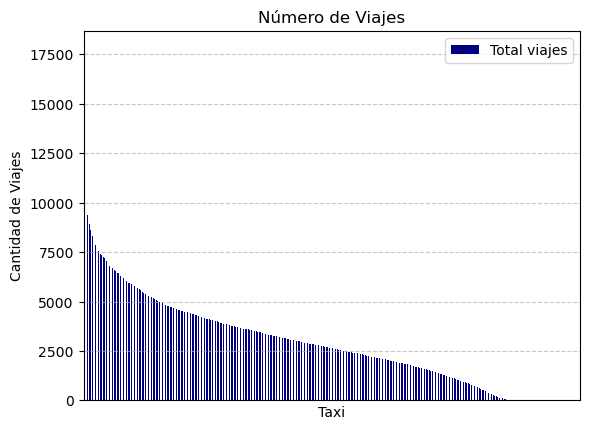

24/12/14 19:31:55 WARN BlockManagerMaster: Failed to remove broadcast 146 with removeFromMaster = true - org.apache.spark.SparkException: Could not find BlockManagerEndpoint1.
	at org.apache.spark.rpc.netty.Dispatcher.postMessage(Dispatcher.scala:178)
	at org.apache.spark.rpc.netty.Dispatcher.postRemoteMessage(Dispatcher.scala:136)
	at org.apache.spark.rpc.netty.NettyRpcHandler.receive(NettyRpcEnv.scala:683)
	at org.apache.spark.network.server.TransportRequestHandler.processRpcRequest(TransportRequestHandler.java:163)
	at org.apache.spark.network.server.TransportRequestHandler.handle(TransportRequestHandler.java:109)
	at org.apache.spark.network.server.TransportChannelHandler.channelRead0(TransportChannelHandler.java:140)
	at org.apache.spark.network.server.TransportChannelHandler.channelRead0(TransportChannelHandler.java:53)
	at io.netty.channel.SimpleChannelInboundHandler.channelRead(SimpleChannelInboundHandler.java:99)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannel

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
num_viajes_df.plot(kind='bar', color='navy')
plt.title('Número de Viajes')
plt.xlabel('Taxi')
plt.ylabel('Cantidad de Viajes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks([])
plt.show()

**Hipótesis**

Es posible que aquellos táxistas que tienen más tiempo, son lo que tienen más viajes, y aquellos con menos viajes son los taxistas que van iniciando

**Taxista con más viajes en el tiempo**

In [80]:
from pyspark.sql.functions import month, year, col

# Obtener el Taxi ID con más viajes
taxista_top1_viajes = num_viajes.first()['Taxi ID']

# Filtrar el DataFrame para el taxi con más viajes
taxista_df_masviajes = df.filter(col('Taxi ID') == taxista_top1_viajes)

# Extraer el año y el mes de 'Trip Start Timestamp' y contar los viajes por mes
trips_by_month = taxista_df_masviajes.groupBy(year('Trip Start Timestamp').alias('Año'),
                                               month('Trip Start Timestamp').alias('Mes')) \
                                       .agg(count('Trip ID').alias('Total Viajes')) \
                                       .orderBy('Año', 'Mes')



In [81]:
trips_by_month_df = trips_by_month.toPandas()
trips_by_month_df["Dia"] = 1
trips_by_month_df['fecha'] = trips_by_month_df['Año'].astype(str) + '-' + trips_by_month_df['Mes'].astype(str).str.zfill(2) + '-' + trips_by_month_df['Dia'].astype(str).str.zfill(2)

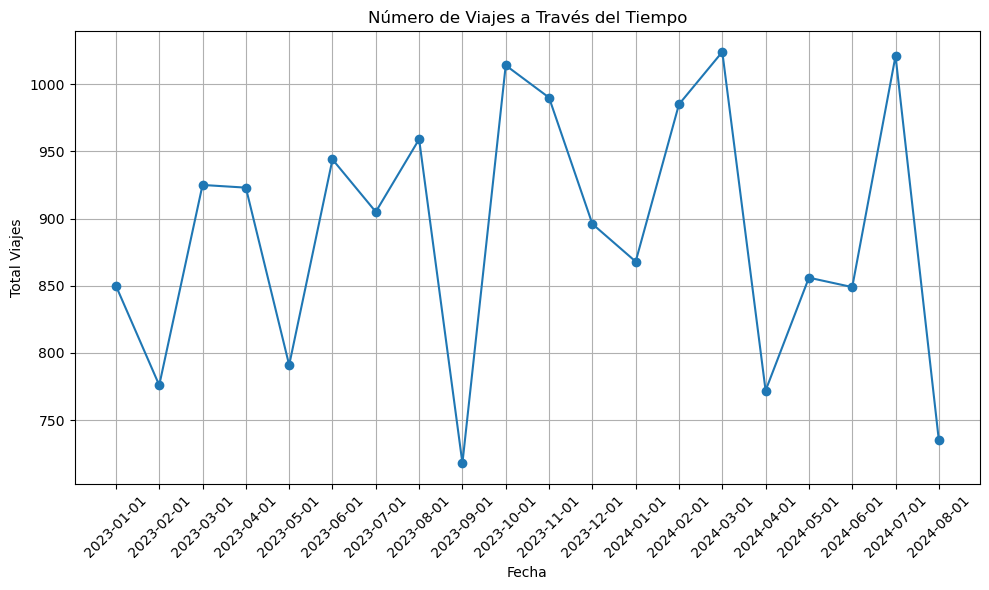

In [103]:
# Graficar
plt.figure(figsize=(10, 6))
plt.plot(trips_by_month_df['fecha'], trips_by_month_df['Total Viajes'], marker='o', linestyle='-')
plt.title('Número de Viajes a Través del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Total Viajes')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

**Taxista con menos viajes en el tiempo**

In [104]:
# Obtener el Taxi ID con menos viajes
taxista_notop_viajes = num_viajes.orderBy('Total viajes', ascending=True).first()['Taxi ID']
taxista_df_menosviajes = df.filter(col('Taxi ID') == taxista_notop_viajes)
trips_by_month = taxista_df_menosviajes.groupBy(year('Trip Start Timestamp').alias('Año'),
                                               month('Trip Start Timestamp').alias('Mes')) \
                                       .agg(count('Trip ID').alias('Total Viajes')) \
                                       .orderBy('Año', 'Mes')

In [105]:
trips_by_month_df = trips_by_month.toPandas()
trips_by_month_df["Dia"] = 1
trips_by_month_df['fecha'] = trips_by_month_df['Año'].astype(str) + '-' + trips_by_month_df['Mes'].astype(str).str.zfill(2) + '-' + trips_by_month_df['Dia'].astype(str).str.zfill(2)

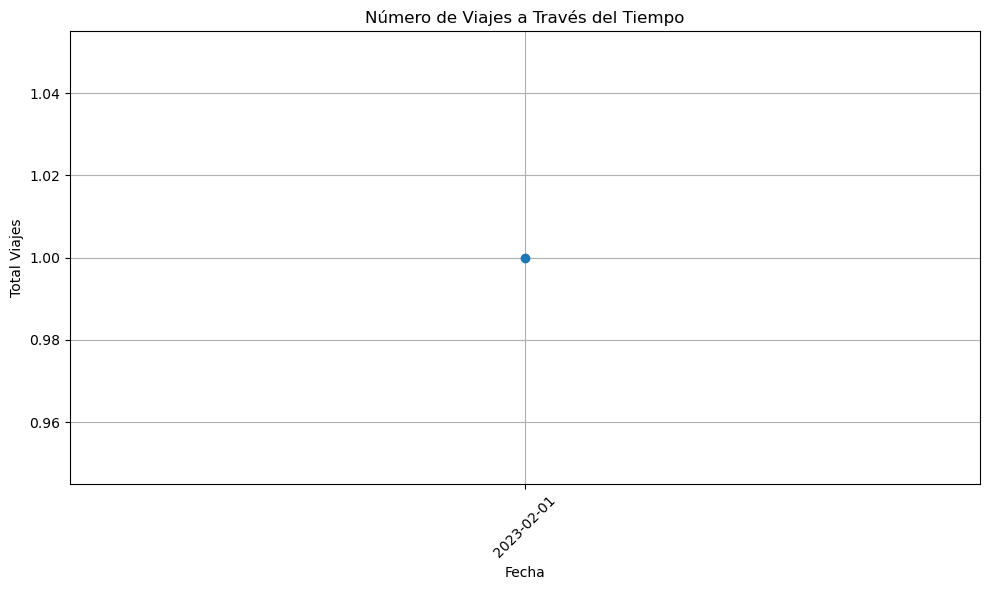

In [106]:
# Graficar
plt.figure(figsize=(10, 6))
plt.plot(trips_by_month_df['fecha'], trips_by_month_df['Total Viajes'], marker='o', linestyle='-')
plt.title('Número de Viajes a Través del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Total Viajes')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

Confirmamos que el taxista que tiene más viajes, lleva trabajando desde 2023, y el taxista con menos viajes solo trabajo un día. 

3. ¿En qué áreas se registran más inicios/descensos de viajes?

Es posible que las zonas más demandadas sean aquellas con mayor cantidad concentraciónde personas, como aeropuertos o centro de la ciudad. 

In [110]:
top_5_pickup_areas = df.groupBy('Pickup Community Area') \
                              .count() \
                              .orderBy('count', ascending=False) \
                              .limit(5)

# Mostrar los resultados
top_5_pickup_areas.show()

+---------------------+-------+
|Pickup Community Area|  count|
+---------------------+-------+
|                    8|2294762|
|                   76|2252599|
|                   32|1738432|
|                   28| 988091|
|                   56| 384493|
+---------------------+-------+



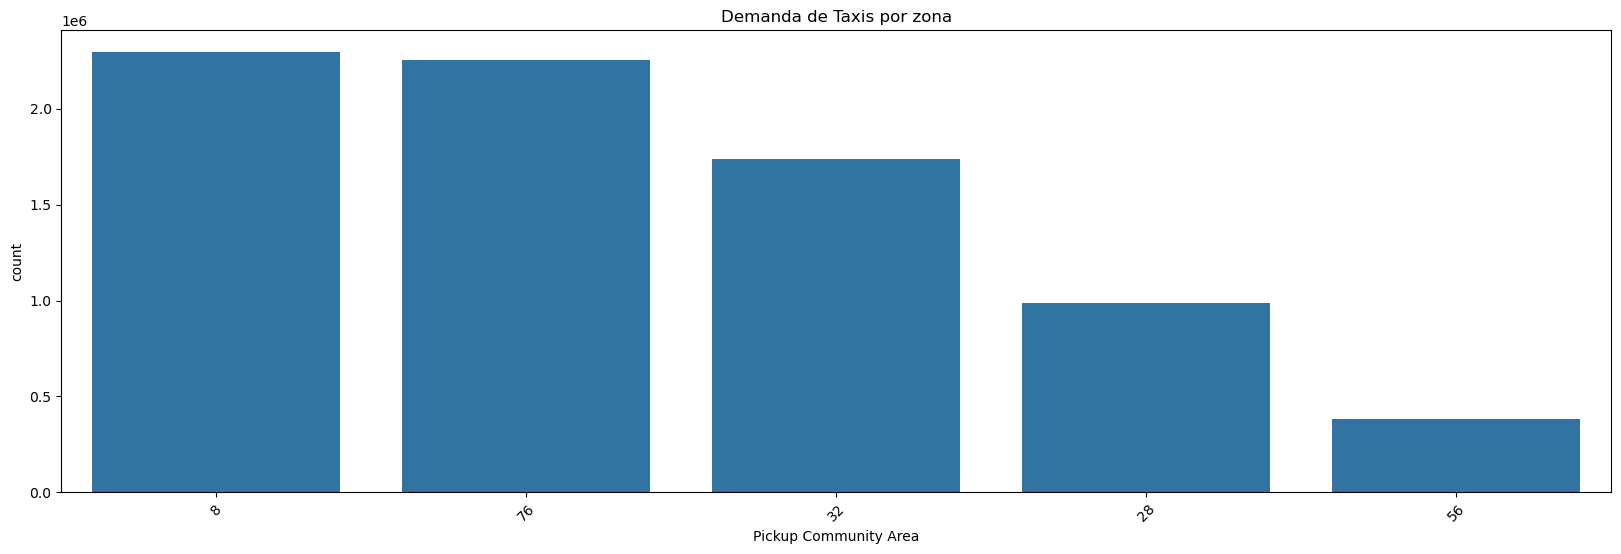

In [115]:
top_5_pickup_areas_df = top_5_pickup_areas.toPandas()

plt.figure(figsize=(20, 6))
sns.barplot(x='Pickup Community Area', y="count", data=top_5_pickup_areas_df)
plt.title('Demanda de Taxis por zona')
plt.xticks(rotation=45)
plt.show()

Las zonas con mayor zonas de recolección de pasajeros son: 
- 8 correspone a Near North que es parte del centro de Chicago
- 76 es O'Hare donde se ubica el Aeropuerto Internacional O'Hare
- 32 es Loop, que es parte del centro de Chicago
- 28 es Near West Side
- 56 es Garfield Ridge se ubica el Aeropuerto Internacional Midway

In [118]:
top_5_dropoff_areas = df.filter(col('Dropoff Community Area').isNotNull()) \
                              .groupBy('Dropoff Community Area') \
                              .count() \
                              .orderBy('count', ascending=False) \
                              .limit(5)

# Mostrar los resultados
top_5_dropoff_areas.show()

+----------------------+-------+
|Dropoff Community Area|  count|
+----------------------+-------+
|                     8|2451261|
|                    32|1712284|
|                    28| 993542|
|                    76| 588696|
|                     6| 480062|
+----------------------+-------+



24/12/14 20:12:52 WARN BlockManagerMaster: Failed to remove broadcast 189 with removeFromMaster = true - org.apache.spark.SparkException: Could not find BlockManagerEndpoint1.
	at org.apache.spark.rpc.netty.Dispatcher.postMessage(Dispatcher.scala:178)
	at org.apache.spark.rpc.netty.Dispatcher.postRemoteMessage(Dispatcher.scala:136)
	at org.apache.spark.rpc.netty.NettyRpcHandler.receive(NettyRpcEnv.scala:683)
	at org.apache.spark.network.server.TransportRequestHandler.processRpcRequest(TransportRequestHandler.java:163)
	at org.apache.spark.network.server.TransportRequestHandler.handle(TransportRequestHandler.java:109)
	at org.apache.spark.network.server.TransportChannelHandler.channelRead0(TransportChannelHandler.java:140)
	at org.apache.spark.network.server.TransportChannelHandler.channelRead0(TransportChannelHandler.java:53)
	at io.netty.channel.SimpleChannelInboundHandler.channelRead(SimpleChannelInboundHandler.java:99)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannel

Las zonas de mayor descenso de pasajeros coincide con las zonas de mayor ascenso de pasajeros

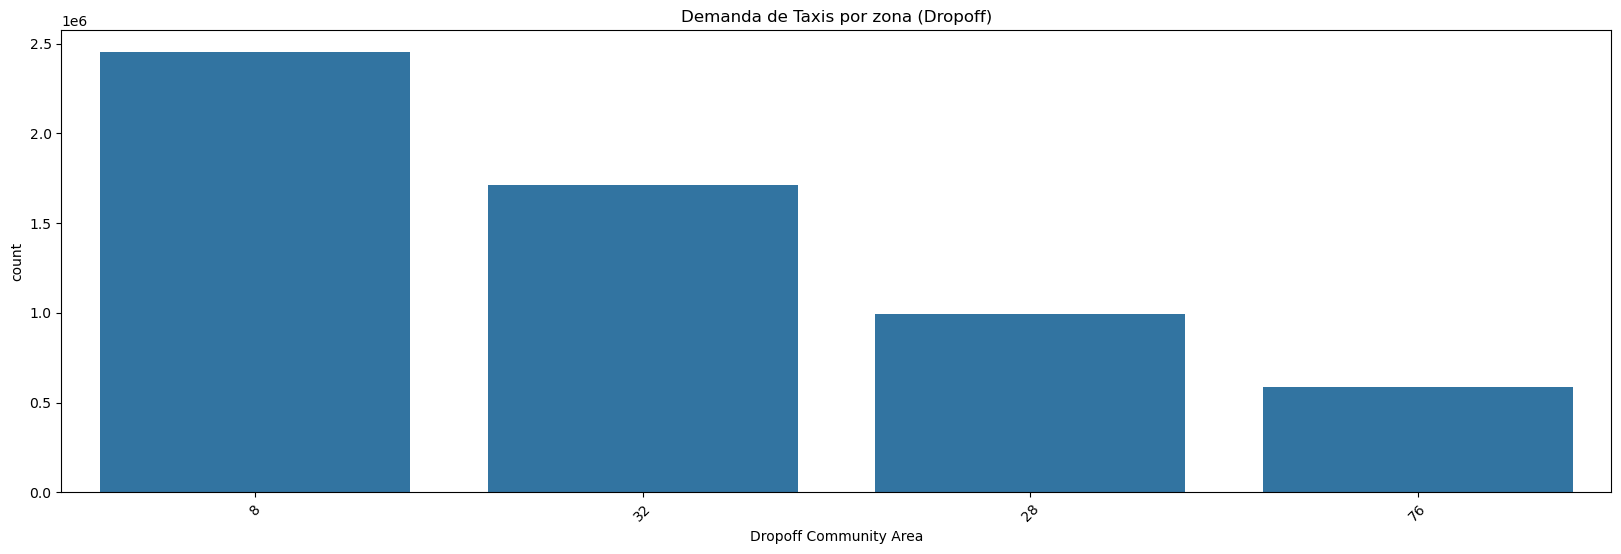

24/12/14 20:11:09 WARN BlockManagerMaster: Failed to remove shuffle 50 - org.apache.spark.SparkException: Could not find BlockManagerEndpoint1.
	at org.apache.spark.rpc.netty.Dispatcher.postMessage(Dispatcher.scala:178)
	at org.apache.spark.rpc.netty.Dispatcher.postRemoteMessage(Dispatcher.scala:136)
	at org.apache.spark.rpc.netty.NettyRpcHandler.receive(NettyRpcEnv.scala:683)
	at org.apache.spark.network.server.TransportRequestHandler.processRpcRequest(TransportRequestHandler.java:163)
	at org.apache.spark.network.server.TransportRequestHandler.handle(TransportRequestHandler.java:109)
	at org.apache.spark.network.server.TransportChannelHandler.channelRead0(TransportChannelHandler.java:140)
	at org.apache.spark.network.server.TransportChannelHandler.channelRead0(TransportChannelHandler.java:53)
	at io.netty.channel.SimpleChannelInboundHandler.channelRead(SimpleChannelInboundHandler.java:99)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerConte

In [117]:
top_5_dropoff_areas = top_5_dropoff_areas.toPandas()

plt.figure(figsize=(20, 6))
sns.barplot(x='Dropoff Community Area', y="count", data=top_5_dropoff_areas)
plt.title('Demanda de Taxis por zona (Dropoff)')
plt.xticks(rotation=45)
plt.show()

## Análisis de Outliers

In [126]:
# Casteo de Trip Seconds
df = df.withColumn("Trip Seconds", col("Trip Seconds").cast("int"))

**Duración del viaje**

In [120]:
count_zeros = df.filter(col('Trip Seconds') == 0).count()

print(f"Total de ceros en Trip Seconds: {count_zeros}")

Total de ceros en Trip Seconds: 204332


Hay viajes con valores igual a 0 en la duración del viaje, que son anómales.

In [127]:
num_bins = 30
min_value = df.agg(F.min('Trip Seconds')).first()[0]
max_value = df.agg(F.max('Trip Seconds')).first()[0]

# Crear bins
bins = [min_value + i * (max_value - min_value) / num_bins for i in range(num_bins + 1)]

# Contar las ocurrencias en cada bin
hist_df = df.select(
    F.when((F.col('Trip Seconds') >= bins[i]) & (F.col('Trip Seconds') < bins[i + 1]), bins[i]).otherwise(None).alias('bin_start')
    for i in range(num_bins)
).dropna()

hist_counts = hist_df.groupBy('bin_start').count().orderBy('bin_start')

# Convertir a pandas para graficar
hist_counts_pd = hist_counts.toPandas()

# Crear el histograma
plt.figure(figsize=(10, 6))
plt.bar(hist_counts_pd['bin_start'], hist_counts_pd['count'], width=(max_value - min_value) / num_bins, color='blue', alpha=0.7)
plt.title('Histograma de Trip Seconds')
plt.xlabel('Trip Seconds')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()

PySparkTypeError: [NOT_COLUMN_OR_STR] Argument `col` should be a Column or str, got generator.

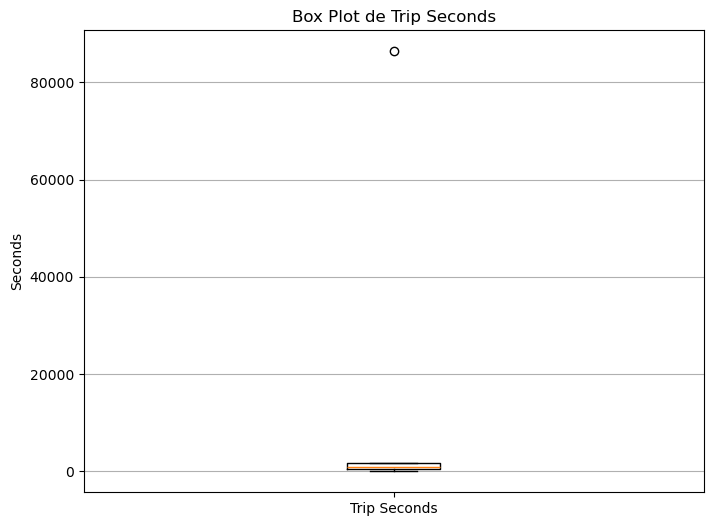

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Calcular estadísticas para el box plot
box_plot_stats = df.select(
    F.percentile_approx('Trip Seconds', 0.25).alias('Q1'),
    F.percentile_approx('Trip Seconds', 0.5).alias('Median'),
    F.percentile_approx('Trip Seconds', 0.75).alias('Q3'),
    F.min('Trip Seconds').alias('Min'),
    F.max('Trip Seconds').alias('Max')
).first()

# Convertir las estadísticas a un DataFrame de pandas
box_plot_df = pd.DataFrame({
    'Stat': ['Min', 'Q1', 'Median', 'Q3', 'Max'],
    'Value': [box_plot_stats['Min'], box_plot_stats['Q1'], box_plot_stats['Median'],
              box_plot_stats['Q3'], box_plot_stats['Max']]
})

# Crear el gráfico de caja
plt.figure(figsize=(8, 6))
plt.boxplot(box_plot_df['Value'], labels=['Trip Seconds'])
plt.title('Box Plot de Trip Seconds')
plt.ylabel('Seconds')
plt.grid(axis='y')
plt.show()

In [151]:
percentiles = [x / 10 for x in range(1, 10)] + [0.01, 0.02, 0.03, 0.97, 0.98, 0.99]

# Calcular estadísticas descriptivas para 'Trip Seconds'
trip_seconds_stats = df.approxQuantile("Trip Seconds", percentiles, 0.01)

# Crear un DataFrame para mostrar los resultados
import pandas as pd

# Convertir a un DataFrame de pandas para facilitar la visualización
trip_seconds_df = pd.DataFrame({
    'Percentiles': percentiles,
    'Trip Seconds': trip_seconds_stats
})

trip_seconds_df.sort_values("Percentiles")

,Percentiles,Trip Seconds
9,0.01,1.0
10,0.02,12.0
11,0.03,24.0
0,0.10,264.0
1,0.20,420.0
2,0.30,565.0
3,0.40,733.0
4,0.50,960.0
5,0.60,1247.0
6,0.70,1560.0


In [144]:
percentile_99 = trip_seconds_df[trip_seconds_df['Percentiles'] == 0.99]["Trip Seconds"].iloc[0]
percentile_99

86382.0

**Filtrando para viajes válidos**

In [148]:
df = df.filter(
    (col("Trip Seconds") > 0) &
    (col("Trip Seconds") < percentile_99)
)

In [158]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

def create_boxplot(df_spark, columns, title='Boxplot', figsize=(12, 8)):
    """
    Crea un boxplot para las columnas especificadas de un DataFrame de Spark.
    
    :param df_spark: DataFrame de Spark que contiene los datos.
    :param columns: Lista de nombres de columnas a visualizar.
    :param title: Título del gráfico.
    :param figsize: Tamaño de la figura.
    """
    # Verificar que todas las columnas existan en el DataFrame
    for col in columns:
        if col not in df_spark.columns:
            raise ValueError(f"La columna '{col}' no existe en el DataFrame de Spark.")

    # Calcular estadísticas para las columnas especificadas
    box_plot_stats = df_spark.select(
        [F.percentile_approx(col, 0.25).alias(f'{col}_Q1') for col in columns] +
        [F.percentile_approx(col, 0.5).alias(f'{col}_Median') for col in columns] +
        [F.percentile_approx(col, 0.75).alias(f'{col}_Q3') for col in columns] +
        [F.min(col).alias(f'{col}_Min') for col in columns] +
        [F.max(col).alias(f'{col}_Max') for col in columns]
    ).first()

    # Verificar que las estadísticas se hayan calculado
    if not box_plot_stats:
        raise ValueError("No se pudieron calcular estadísticas para las columnas especificadas.")

    # Convertir las estadísticas a un DataFrame de pandas
    box_plot_data = {
        'Stat': [],
        **{col: [] for col in columns}
    }

    # Recoger estadísticas en un formato adecuado para el boxplot
    for col in columns:
        box_plot_data['Stat'].extend(['Min', f'{col}_Q1', f'{col}_Median', f'{col}_Q3', 'Max'])
        box_plot_data[col].extend([box_plot_stats[f'{col}_Min'], box_plot_stats[f'{col}_Q1'],
                                    box_plot_stats[f'{col}_Median'], box_plot_stats[f'{col}_Q3'],
                                    box_plot_stats[f'{col}_Max']])

    # Crear el DataFrame de Pandas
    box_plot_df = pd.DataFrame(box_plot_data)

    # Verificar que todas las columnas tengan la misma longitud
    for col in columns:
        if len(box_plot_df[col]) != len(box_plot_df['Stat']):
            raise ValueError(f"Desajuste en la longitud de las columnas para '{col}'.")

    # Configurar el tamaño de la figura
    plt.figure(figsize=figsize)

    # Crear el boxplot utilizando sns.boxplot
    # Usamos melt para transformar el DataFrame en formato largo
    melted_df = box_plot_df.melt(id_vars='Stat', var_name='Variable', value_name='Value')

    # Crear el boxplot con el argumento hue
    sns.boxplot(data=melted_df, x='Value', y='Variable', hue='Variable', palette='Set2', legend=False)

    # Etiquetas y título
    plt.xlabel('Valor')
    plt.title(title)
    plt.grid(True)

    # Mostrar el plot
    plt.show()

# Ejemplo de uso
# create_boxplot(df_spark, ['Fare', 'Tips', 'Tolls', 'Extras'], title='Boxplot de Monto Total')



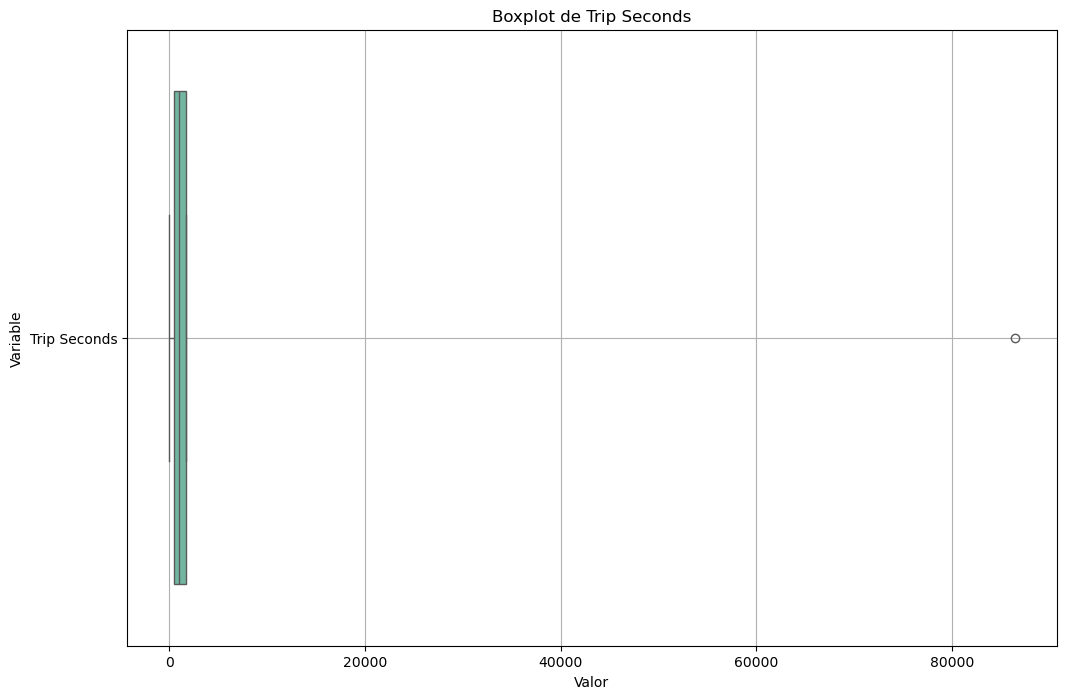

In [159]:
create_boxplot(df, ["Trip Seconds"], title="Boxplot de Trip Seconds")

#### Fare, Tips, Tolls, Extras (preliminar)

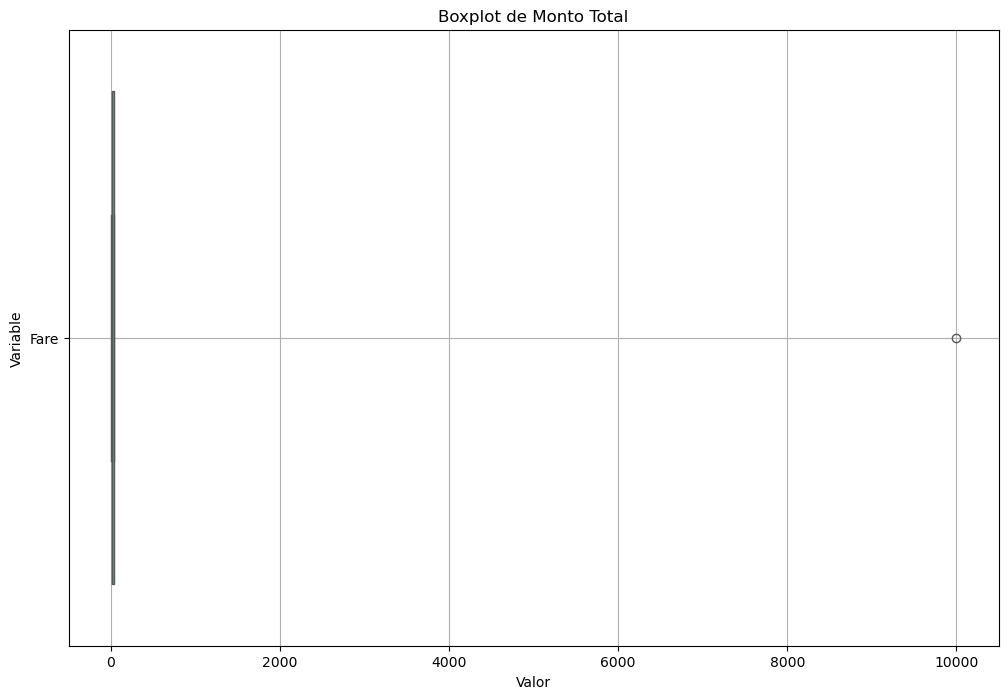

In [161]:
create_boxplot(df, ['Fare'], title='Boxplot de Monto Total')